# Example notebook

Displays how the EM module works on an RIR in the folder.

Section 1 shows how to load an RIR from a wav file, learn its parameters with the EM algorithm and save the results in a pickle file.

Section 2 shows how to load the parameters learned previously and generate and artificial RIR from them

The two sections are independent.

In [1]:
from __future__ import print_function
import numpy as np
from IPython.display import clear_output
import sys

from scipy import signal
from scipy.linalg import toeplitz
import time
import scipy.io

import matplotlib.pyplot as plt

import pickle
    
import EM
import IPython.display as ipd
from matplotlib import cm
import soundfile as sf

In [2]:
# Definition of the progress bar function for better readability
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [3]:
def dB(x):
    return 10*np.log10(x)

# Section 1

### Load example RIR
Load an exemple RIR from a wav file.

In [4]:
filename = "RIRs/roomsimove_2.wav"

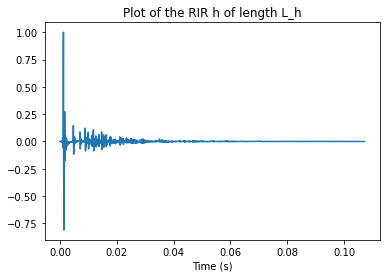

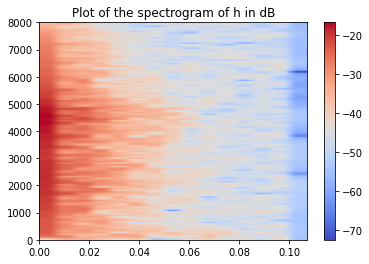

In [5]:
h, h_fs = sf.read(filename)

#h_fs, h = read(filename)

#Sampling frequency we want to work with
#Must be less than the RIR's sampling frequency
fs = 16000

#Maximum number of samples we want the RIR to have
L_h = 8000

h_full_length = signal.resample_poly(h,1,int(h_fs/fs))#/np.amax(h)
h=h_full_length[:min(L_h, h_full_length.shape[0])]

L_h = h.shape[0]

plt.plot(np.arange(L_h)/fs, h)
plt.xlabel("Time (s)")
plt.title("Plot of the RIR h of length L_h")
plt.show()


f, t, H = signal.stft(h)
plt.imshow(dB(np.abs(H)), origin="lower", aspect="auto", extent=[0,L_h/fs,0,fs/2], cmap=cm.coolwarm)
plt.title("Plot of the spectrogram of h in dB")
plt.colorbar()
plt.show()

### Initialize EM algorithm

In [6]:
algo = EM.EM(h, la=1e-1)

Initialization of the EM algorithm
la init = 0.1

Updating R

Updating mu
diff = 14320.440116219139 (should be positive after M step)


### Iterate 100 times the expectation and maximization steps

In [7]:
n_iter = 200

for i in range(n_iter):
    update_progress(i / n_iter)
    algo.iteration()

update_progress(1)

Progress: [####################] 100.0%


### Plot results

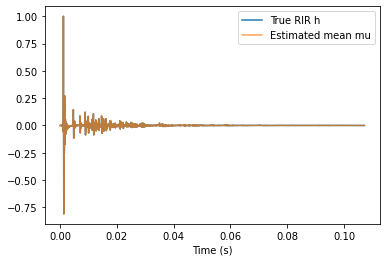

In [8]:
plt.plot(np.arange(L_h)/fs, h, label="True RIR h")
plt.plot(np.arange(L_h)/fs, algo.mu, alpha=0.7, label="Estimated mean mu")
plt.legend()
plt.xlabel("Time (s)")
plt.show()

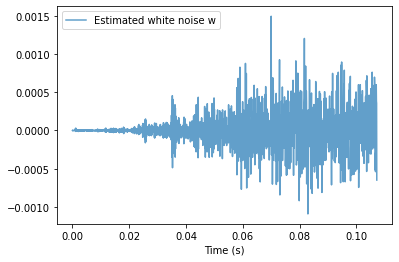

In [9]:
plt.plot(np.arange(L_h)/fs, algo.w, alpha=0.7, label="Estimated white noise w")
plt.legend()
plt.xlabel("Time (s)")
plt.show()

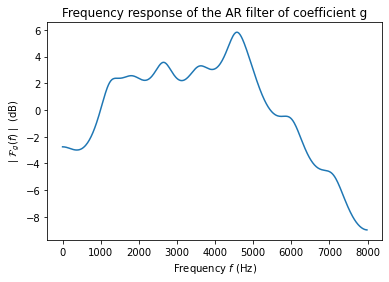

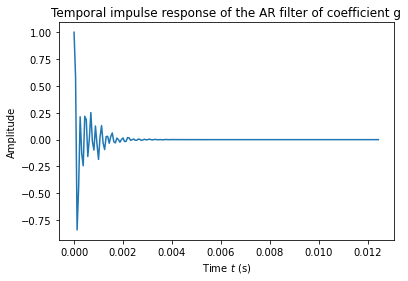

In [10]:
N_FFT = 1024
f = plt.figure()
axes = f.gca()

delta = np.zeros(200)
delta[0] = 1
# Estimated frequency response of g
fft_est = np.abs(1/np.fft.fft(algo.g,N_FFT))
fft_est_norm = fft_est/np.sqrt(np.sum(np.square(fft_est)))

# Show the true and estimated frequency responses in dB
plt.plot(fs*np.arange(N_FFT/2)/N_FFT,dB(fft_est[:int(N_FFT/2)]))
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("$\mid \mathcal{F}_g(f) \mid$ (dB)")
plt.title("Frequency response of the AR filter of coefficient g")
#axes.set_xscale("log")
plt.show()

#Show the corresponding temporal responses
plt.plot(1/fs*np.arange(200),signal.lfilter([1], algo.g, delta))
plt.xlabel("Time $t$ (s)")
plt.ylabel("Amplitude")
plt.title("Temporal impulse response of the AR filter of coefficient g")
plt.show()

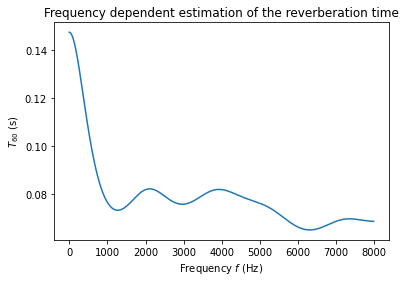

In [11]:
# Estimated T60
T60_est = np.abs(1/np.fft.fft(algo.p,N_FFT))
T60_est = -3*np.log(10)/(np.log(np.exp(-algo.a)/np.abs(np.fft.fft(algo.p,N_FFT)[:int(N_FFT/2)]))*fs)

# Show the true and estimated frequency dependent T60
plt.plot(fs*np.arange(N_FFT/2)/N_FFT,T60_est)
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("$T_{60}$ (s)")
plt.title("Frequency dependent estimation of the reverberation time")
plt.show()

### Save the parameters

In [12]:
EM.save_algo("EM saves/example", algo, fs)

# Section 2

### Load EM parameters and full length true RIR

In [13]:
filename = "MARDY_ir_2_C_4"
algo, fs = EM.load_algo("EM saves/{}_it200".format(filename))

Last log-probability evaluation: 92200.09820010532
Room volume: 208.8
Initialization of the EM algorithm
la init = 0.0059160822132734445

Updating R

Updating mu
diff = 92200.09820010532 (should be positive after M step)


In [14]:
h, h_fs = sf.read("RIRs/{}.wav".format(filename))

#Maximum number of samples we want the RIR to have
L_h = 8000

h_full_length = signal.resample_poly(h,1,int(h_fs/fs))/np.amax(h)
h=h_full_length[:min(L_h, h_full_length.shape[0])]

L_h = h.shape[0]

### Generate RIR from the learned parameters

In [15]:
L_h_gen = min(15000, h_full_length.shape[0])
np.random.seed(1)


pi_gen = np.random.randn(L_h_gen)*np.sqrt(algo.la)
Gpi_gen = signal.lfilter([1], algo.g, pi_gen)

q = np.exp(algo.a)*algo.p
delta = np.zeros(L_h_gen-1)
delta[0] = 1
q_inv = signal.lfilter([1], q, delta)
Q_inv = EM.P_class(q_inv[:20])
mu_gen = np.dot(Q_inv.matrix(L_h_gen), Gpi_gen)


w_gen = np.random.randn(L_h_gen)*np.sqrt(algo.sigma2)
h_gen = mu_gen + w_gen

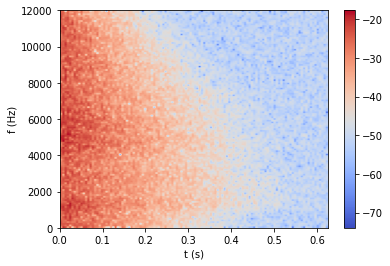

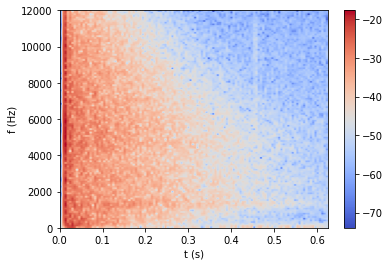

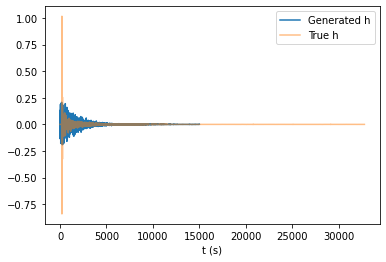

In [16]:
H_gen = dB(np.abs(signal.stft(h_gen)[2]))[:,:-1]
H = dB(np.abs(signal.stft(h_full_length[:h_gen.shape[0]])[2]))[:,:-1]
vmin = max(np.amin(H_gen),np.amin(H))
vmax = min(np.amax(H_gen),np.amax(H))

plt.imshow(H_gen, origin="lower", aspect="auto", vmin = vmin, vmax = vmax, extent=[0,L_h_gen/fs,0,fs/2], cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.show()
plt.imshow(H, origin="lower", aspect="auto", vmin = vmin, vmax = vmax, extent=[0,L_h_gen/fs,0,fs/2], cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.show()
plt.plot(h_gen, label="Generated h")
plt.plot(h_full_length, alpha=0.5, label="True h")
plt.legend()
plt.xlabel('t (s)')
plt.show()

### Use the generated filter on an anechoic signal

In [17]:
audio, audio_fs = sf.read("Audio examples/Other examples/audio_anechoic.wav")
audio = signal.resample_poly(audio,1, int(audio_fs/fs))
audio_h_true = np.convolve(audio, h_full_length)
audio_h_gen = np.convolve(audio, h_gen)

#### Anechoic signal

In [18]:
ipd.Audio(audio, rate=fs, autoplay=False)

#### Signal convolved by true RIR

In [19]:
ipd.Audio(audio_h_true, rate=fs, autoplay=False)

#### Signal convolved by generated RIR

In [20]:
ipd.Audio(audio_h_gen, rate=fs, autoplay=False)